# 분류 평가 지표

### MNIST Dataset

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [3]:
mnist = fetch_openml("mnist_784", version=1, as_frame=False)

print(type(mnist))
print(mnist.keys())

<class 'sklearn.utils.Bunch'>
dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [ ]:
X = mnist["data"]
y = mnist["target"]

print(X.shape, y.shape)
print(28 * 28)

In [ ]:
some_digit = X[0]
print(some_digit.shape)
some_digit_img = some_digit.reshape(28, 28)
print(some_digit_img.shape)

In [ ]:
plt.imshow(some_digit_img, cmap="binary")

In [ ]:
y[0]

In [ ]:
y = y.astype(np.uint8)

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
for i in range(10):
    print("label 분포",i, (y_train == i).sum())

### 이진 분류

In [ ]:
y_train_5 = (y_train == 5).astype(np.uint8) # 5인지 아닌지를 분류 : "5"이면 1, "5"가 아니면 0
y_test_5 = (y_test == 5).astype(np.uint8)

In [ ]:
y_train_5, y_test_5

In [ ]:
(y_train_5 == 1).sum(), (y_train_5 == 0).sum() # 10%:90%의 불균형한 데이터셋

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
X_train.shape, y_train_5.shape

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

In [ ]:
from sklearn.base import BaseEstimator

class Nerver5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=np.uint8) # 0을 return : 무조건 5가 아니라고 예측

In [ ]:
never_5_clf = Nerver5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy") 
# 가짜 분류기에도 90%의 성능이 나오므로 이 예측기는 신뢰할 수 없음

In [79]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) 

In [92]:
y_train_pred

array([1, 0, 0, ..., 1, 0, 0], dtype=uint8)

In [81]:
y_train_pred.shape

(60000,)

#### 오차행렬

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [83]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [86]:
precision_score(y_train_5, y_train_pred) # 정밀도 3530 / (687 + 3530)

0.8370879772350012

In [87]:
recall_score(y_train_5, y_train_pred) # 재현율 3530 / (1891 + 3530)

0.6511713705958311

In [89]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [94]:
y_score = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function") 

In [95]:
y_score

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [97]:
y_train_pred

array([1, 0, 0, ..., 1, 0, 0], dtype=uint8)

In [106]:
## 샘플의 확신 점수 알아보기
threshold = 0

y_score > threshold  # y_train_5

sgd_clf.decision_function([some_digit])

sgd_clf.predict([some_digit])

In [ ]:
## 임계값 변경 (확신 점수에 대한 임계값을 올리므로 "5"에 대한 예측이 정밀해짐)

threshold = 8000

y_train_pred_th8000 = y_score > threshold

confusion_matrix(y_train_5, y_train_pred_th8000)

precision_score(y_train_5, y_train_pred_th8000) # threshold 적용 전 0.8370879772350012

recall_score(y_train_5, y_train_pred_th8000) # threshold 적용 전 0.6511713705958311

In [121]:
from sklearn.metrics import precision_recall_curve

In [122]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_score)

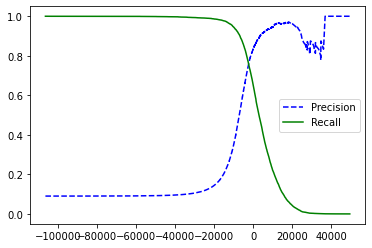

In [130]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.legend(loc="center right")
plt.show()

In [134]:
thresholds[np.argmax(precisions >= 0.9)]

3370.0194991439557

In [137]:
## 임계값 변경 (확신 점수에 대한 임계값을 올리므로 "5"에 대한 예측이 정밀해짐)

threshold = 3370

y_train_pred_90 = y_score > threshold


print("Precision:", precision_score(y_train_5, y_train_pred_90))

print("Recall:", recall_score(y_train_5, y_train_pred_90))

Precision: 0.9000345901072293
Recall: 0.4799852425751706


#### ROC 곡선

In [144]:
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score

In [140]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_score)

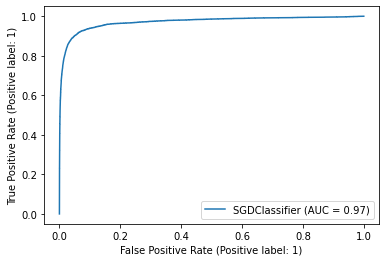

In [143]:
plot_roc_curve(sgd_clf, X_train, y_train_5)

In [146]:
roc_auc_score(y_train_5, y_score)

0.9604938554008616

### 다중 분류

#### SVM Classifier

In [148]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])

SVC(gamma='auto', random_state=42)

In [150]:
svm_clf.predict([some_digit])  # '5' image

array([5], dtype=uint8)

In [153]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [154]:
np.argmax(some_digit_scores)

5

In [157]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

#### SGD Classifier

In [160]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [161]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
# scale 전
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scroing="accuracy")

In [163]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [ ]:
# scale 후
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scroing="accuracy")

In [164]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [167]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

In [165]:
import seaborn as sns

<AxesSubplot:>

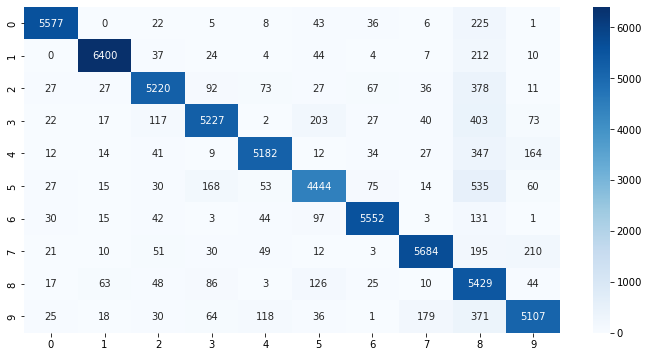

In [169]:
plt.figure(figsize=(12, 6))
sns.heatmap(conf_mx, cmap="Blues", annot=True, fmt='.0f')

In [174]:
row_sums = conf_mx.sum(axis=1)
norm_conf_mx = conf_mx / row_sums

<AxesSubplot:>

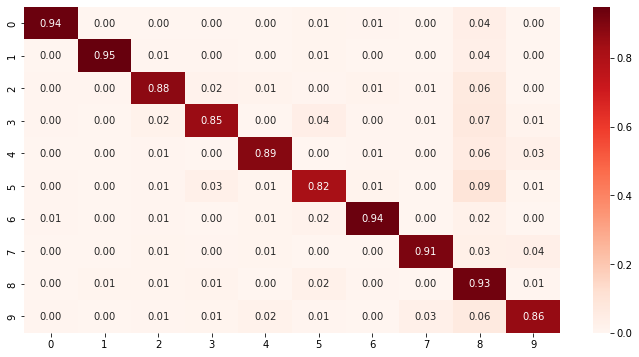

In [175]:
plt.figure(figsize=(12, 6))
sns.heatmap(norm_conf_mx, cmap="Reds", annot=True, fmt='.2f')